In [9]:
# ======================
# 1. INITIAL SETUP & PATHS
# ======================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Configure paths
BASE_DIR = "/kaggle/input/mydataset"
CSV_PATH = os.path.join(BASE_DIR, "driver_imgs_list.csv")
TRAIN_DIR = os.path.join(BASE_DIR, "imgs-20250324T220316Z-001/imgs/train") 
TEST_DIR = os.path.join(BASE_DIR, "imgs-20250324T220316Z-001/imgs/test")

print("✅ Setup completed - verifying paths...")
assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}"
assert os.path.exists(TRAIN_DIR), f"Train dir not found at {TRAIN_DIR}"
assert os.path.exists(TEST_DIR), f"Test dir not found at {TEST_DIR}"
print("✅ All paths verified!")

✅ Setup completed - verifying paths...
✅ All paths verified!


In [10]:
# ======================
# 2. DATA LOADING
# ======================
df = pd.read_csv(CSV_PATH)
print("\nData loaded successfully!")
print("First 5 rows:")
print(df.head())

# Verify image files exist
sample_img_path = os.path.join(TRAIN_DIR, df.iloc[0]['classname'], df.iloc[0]['img'])
print(f"\nTesting sample image at: {sample_img_path}")
assert os.path.exists(sample_img_path), "Sample image not found!"
print("✅ Sample image verified")

print("\nClass distribution:")
print(df['classname'].value_counts())


Data loaded successfully!
First 5 rows:
  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

Testing sample image at: /kaggle/input/mydataset/imgs-20250324T220316Z-001/imgs/train/c0/img_44733.jpg
✅ Sample image verified

Class distribution:
classname
c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: count, dtype: int64


In [7]:
# Split data (80% train, 10% val, 10% test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['classname'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['classname'])

print("\nData splitting completed:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Data splitting completed:
Training samples: 17939
Validation samples: 2242
Test samples: 2243


In [11]:
# ======================
# 3. DATA GENERATORS
# ======================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

print("\nCreating generators...")
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation' 
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n✅ Generators created:")
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Test samples: {test_gen.samples}")


Creating generators...
Found 17526 images belonging to 10 classes.
Found 4377 images belonging to 10 classes.
Found 0 images belonging to 0 classes.

✅ Generators created:
Training samples: 17526
Validation samples: 4377
Test samples: 0


In [12]:
# ======================
# 4. MODEL BUILDING
# ======================
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

def build_model():
    base_model = VGG16(
        weights='imagenet', 
        include_top=False, 
        input_shape=(*IMG_SIZE, 3)
    )
    
    # Freeze base layers
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = build_model()
print("\n✅ Model built successfully!")
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

✅ Model built successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
# ======================
# 5. MODEL TRAINING (FIXED)
# ======================
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)  # Changed .h5 to .keras
]

print("\nStarting training...")
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")


Starting training...
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


548/548 ━━━━━━━━━━━━━━━━━━━━ 341s 594ms/step - accuracy: 0.1900 - loss: 2.2454 - val_accuracy: 0.5412 - val_loss: 1.6695
Epoch 2/30
548/548 ━━━━━━━━━━━━━━━━━━━━ 250s 452ms/step - accuracy: 0.4294 - loss: 1.6705 - val_accuracy: 0.6740 - val_loss: 1.2565
Epoch 3/30
548/548 ━━━━━━━━━━━━━━━━━━━━ 249s 450ms/step - accuracy: 0.5371 - loss: 1.3890 - val_accuracy: 0.7546 - val_loss: 1.0284
Epoch 4/30
548/548 ━━━━━━━━━━━━━━━━━━━━ 249s 450ms/step - accuracy: 0.6099 - loss: 1.1793 - val_accuracy: 0.7973 - val_loss: 0.8847
Epoch 5/30
548/548 ━━━━━━━━━━━━━━━━━━━━ 249s 450ms/step - accuracy: 0.6540 - loss: 1.0746 - val_accuracy: 0.8197 - val_loss: 0.7880
Epoch 6/30
548/548 ━━━━━━━━━━━━━━━━━━━━ 250s 451ms/step - accuracy: 0.6861 - loss: 0.9647 - val_accuracy: 0.8348 - val_loss: 0.6692
Epoch 7/30
548/548 ━━━━━━━━━━━━━━━━━━━━ 248s 448ms/step - accuracy: 0.7095 - loss: 0.9000 - val_accuracy: 0.8663 - val_loss: 0.5699
Epoch 8/30
548/548 ━━━━━━━━━━━━━━━━━━━━ 249s 450ms/step - accuracy: 0.7402 - loss: 0.82

In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# 1. Load your original model
model = load_model('best_model.keras', compile=True)

# 2. Unfreeze more VGG16 layers (15 last conv layers)
for layer in model.layers[0].layers[-15:]:
    layer.trainable = True

# 3. Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Reduced from 1e-4
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Continue training until epoch 40
continued_history = model.fit(
    train_gen,  
    epochs=40,  # Stop exactly at epoch 40
    initial_epoch=30,  
    validation_data=val_gen,
    callbacks=[
        ModelCheckpoint('final_model.keras')
    ]
)

# 5. Final evaluation (Commented out to prevent errors)
# test_loss, test_acc = model.evaluate(test_gen)
# print(f"\n🚀 FINAL TEST ACCURACY: {test_acc:.2%}") ========> this is causing the error but its fixed later on to avoid
# retraining the model


Epoch 31/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 296s 522ms/step - accuracy: 0.8505 - loss: 0.4466 - val_accuracy: 0.9593 - val_loss: 0.1518
Epoch 32/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 255s 460ms/step - accuracy: 0.9099 - loss: 0.2881 - val_accuracy: 0.9648 - val_loss: 0.1247
Epoch 33/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 254s 458ms/step - accuracy: 0.9197 - loss: 0.2519 - val_accuracy: 0.9657 - val_loss: 0.1132
Epoch 34/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 259s 468ms/step - accuracy: 0.9363 - loss: 0.1893 - val_accuracy: 0.9810 - val_loss: 0.0669
Epoch 35/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 254s 459ms/step - accuracy: 0.9479 - loss: 0.1572 - val_accuracy: 0.9836 - val_loss: 0.0562
Epoch 36/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 255s 460ms/step - accuracy: 0.9615 - loss: 0.1372 - val_accuracy: 0.9845 - val_loss: 0.0535
Epoch 37/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 259s 467ms/step - accuracy: 0.9599 - loss: 0.1237 - val_accuracy: 0.9861 - val_loss: 0.0416
Epoch 38/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 258s 466ms/step - accuracy: 

ValueError: Must provide at least one structure

In [47]:
# Save the model
model.save("final_model.keras")

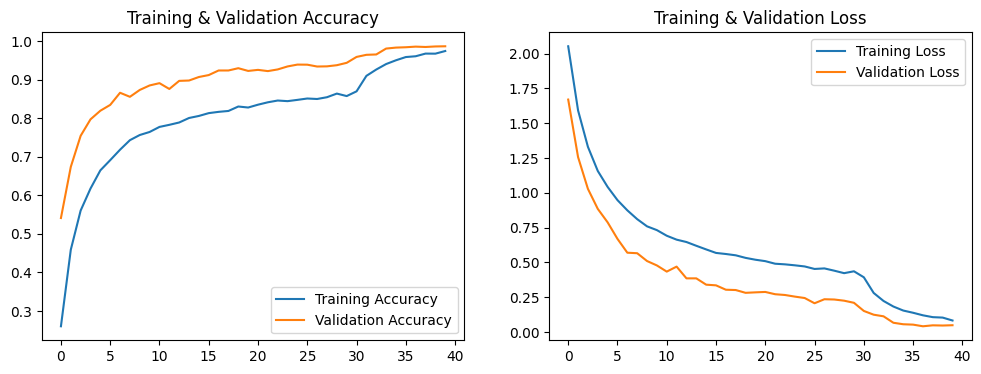

In [46]:
import matplotlib.pyplot as plt

# Combine both training histories (first 40 epochs + continued training)
def plot_history(history, continued_history=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if continued_history:
        acc += continued_history.history['accuracy']
        val_acc += continued_history.history['val_accuracy']
        loss += continued_history.history['loss']
        val_loss += continued_history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()

# Call function
plot_history(history, continued_history)


In [50]:
import pandas as pd

test_dir = "/kaggle/input/mydataset/imgs-20250324T220316Z-001/imgs/test"
test_images = os.listdir(test_dir)

# Convert test images into a DataFrame
test_df = pd.DataFrame({"filename": test_images})
test_df["filepath"] = test_df["filename"].apply(lambda x: os.path.join(test_dir, x))

print(test_df.head())  # Show first 5 rows


        filename                                           filepath
0  img_96590.jpg  /kaggle/input/mydataset/imgs-20250324T220316Z-...
1  img_99675.jpg  /kaggle/input/mydataset/imgs-20250324T220316Z-...
2  img_85937.jpg  /kaggle/input/mydataset/imgs-20250324T220316Z-...
3  img_89410.jpg  /kaggle/input/mydataset/imgs-20250324T220316Z-...
4  img_81791.jpg  /kaggle/input/mydataset/imgs-20250324T220316Z-...


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


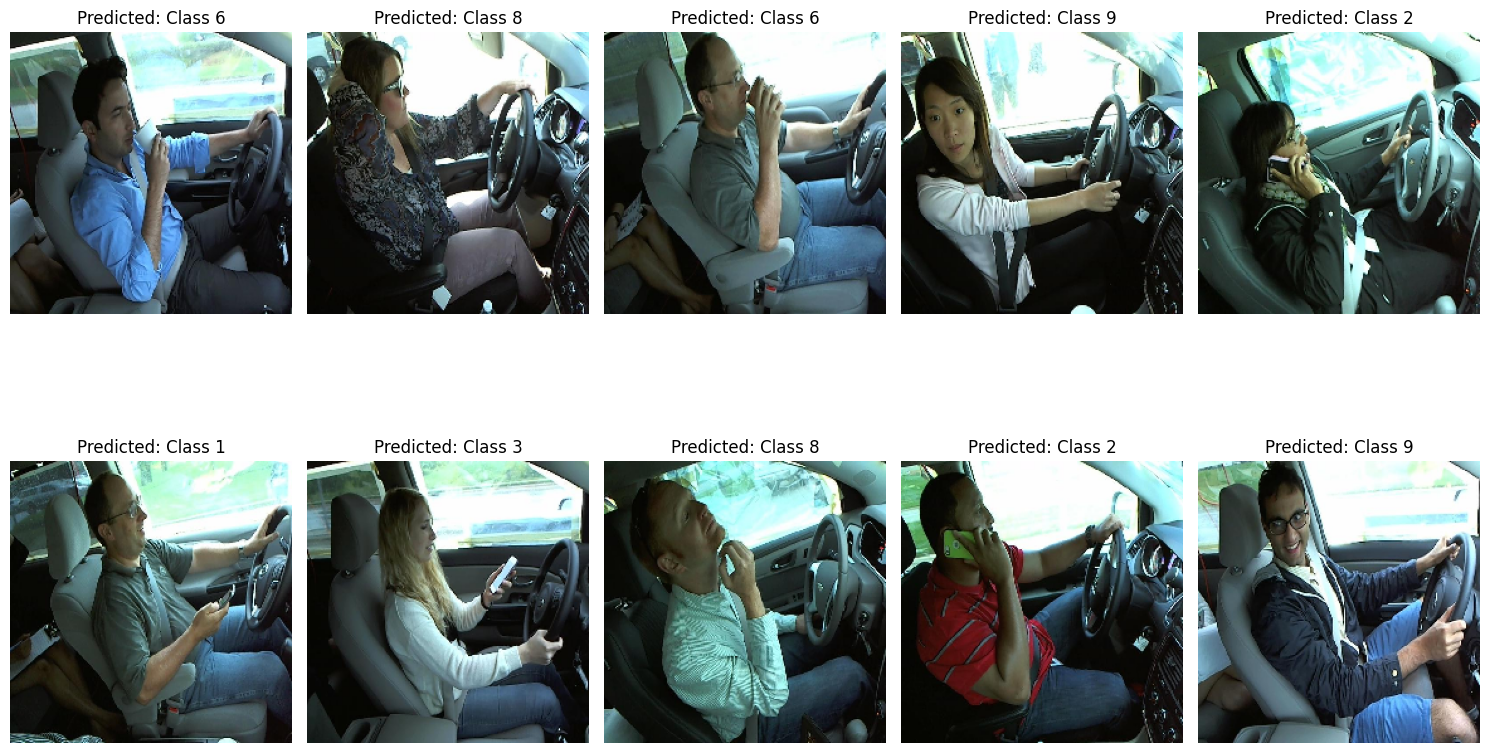

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Test images directory
test_dir = "/kaggle/input/mydataset/imgs-20250324T220316Z-001/imgs/test"
test_images = os.listdir(test_dir)

# Pick 10 random images for visualization
random_images = np.random.choice(test_images, 10, replace=False)

plt.figure(figsize=(15, 10))

for i, img_name in enumerate(random_images):
    img_path = os.path.join(test_dir, img_name)

    # Load and preprocess image
    img = load_img(img_path, target_size=(224, 224))  # Resize to VGG16 input size
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Plot image
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: Class {predicted_class}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [53]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_gen)

print(f"✅ Validation Accuracy: {val_acc * 100:.2f}%")
print(f"✅ Validation Loss: {val_loss:.4f}")


137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 405ms/step - accuracy: 0.9873 - loss: 0.0424
✅ Validation Accuracy: 98.77%
✅ Validation Loss: 0.0448
